In [1]:
import keras
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, MaxPooling2D
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet121
#from keras.applications import ResNet50V2
from keras.applications import InceptionResNetV2
from keras import backend as K
import skimage.io as io
import skimage.transform as trans
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode
import torch
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import gc
from random import randint
init_notebook_mode(connected=True)
%matplotlib inline
np.set_printoptions(threshold=np.inf)
%cd D:\hüseyin
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

train_images = np.load("images1.npy")
train_masks = np.load("masks1.npy")

Using TensorFlow backend.


D:\hüseyin


In [3]:
train_masks = train_masks[:,:,:,5]
print("Folder_1",train_images.shape, train_masks.shape)
unique, counts = np.unique(train_masks, return_counts=True)
dict(zip(unique, counts))

Folder_1 (2656, 256, 256, 3) (2656, 256, 256)


{0.0: 32018870, 1.0: 142044746}

In [4]:
train_masks[train_masks==1] = 2
train_masks[train_masks==0] = 1
train_masks[train_masks==2] = 0
unique, counts = np.unique(train_masks, return_counts=True)
dict(zip(unique, counts))

{0.0: 142044746, 1.0: 32018870}

In [5]:
train_images = train_images/255
train_images.shape, train_masks.shape

((2656, 256, 256, 3), (2656, 256, 256))

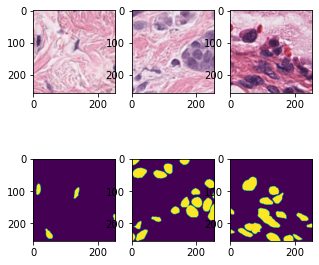

In [6]:
index = 80
f, axarr = plt.subplots(2,3, figsize=(5,5))
axarr[0,0].imshow(train_images[index])
axarr[0,1].imshow(train_images[index+158])
axarr[0,2].imshow(train_images[index+2498])
axarr[1,0].imshow(train_masks[index])
axarr[1,1].imshow(train_masks[index+158])
axarr[1,2].imshow(train_masks[index+2498])

In [37]:
train_masks = train_masks.reshape(train_masks.shape[0],256,256,1)
train_masks.shape

(2656, 256, 256, 1)

In [33]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.summary()
    return model
input_img = Input((256, 256, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 256, 16) 64          conv2d_143[0][0]                 
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 256, 256, 16) 0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
max_poolin

In [40]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
callbacks_list = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('best-model.hdf5', monitor= "loss", verbose=1, save_best_only=True, save_weights_only=True)
]
results = model.fit(train_images, train_masks, batch_size=32, epochs=35, callbacks=callbacks_list)

Epoch 1/35
2656/2656 [==============================] - 716s 269ms/step - loss: 0.3202 - acc: 0.8952


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:1109: RuntimeWarning:

Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr




Epoch 00001: loss improved from inf to 0.32016, saving model to best-model.hdf5
Epoch 2/35
2656/2656 [==============================] - 712s 268ms/step - loss: 0.2498 - acc: 0.9067

Epoch 00002: loss improved from 0.32016 to 0.24977, saving model to best-model.hdf5
Epoch 3/35
2656/2656 [==============================] - 717s 270ms/step - loss: 0.2261 - acc: 0.9107

Epoch 00003: loss improved from 0.24977 to 0.22612, saving model to best-model.hdf5
Epoch 4/35
2656/2656 [==============================] - 715s 269ms/step - loss: 0.2141 - acc: 0.9141

Epoch 00004: loss improved from 0.22612 to 0.21406, saving model to best-model.hdf5
Epoch 5/35
2656/2656 [==============================] - 717s 270ms/step - loss: 0.2097 - acc: 0.9166

Epoch 00005: loss improved from 0.21406 to 0.20966, saving model to best-model.hdf5
Epoch 6/35
2656/2656 [==============================] - 714s 269ms/step - loss: 0.1959 - acc: 0.9206

Epoch 00006: loss improved from 0.20966 to 0.19595, saving model to best-

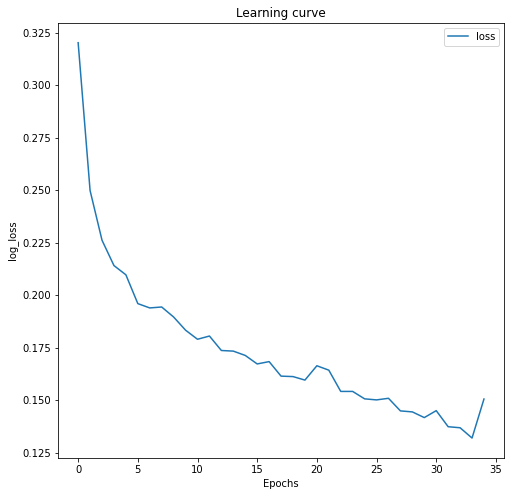

In [41]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.savefig("dice_coef_curve.pdf") 
plt.show()

In [50]:
del train_images, train_masks
model.load_weights('best-model.hdf5')

In [58]:
valid_images = np.load("images2.npy")
valid_masks = np.load("masks2.npy")
valid_images = valid_images/255
valid_masks = valid_masks[:,:,:,5]
valid_masks[valid_masks==1] = 2
valid_masks[valid_masks==0] = 1
valid_masks[valid_masks==2] = 0
valid_masks = valid_masks.reshape(valid_masks.shape[0],256,256,1)
valid_images.shape, valid_masks.shape

((2523, 256, 256, 3), (2523, 256, 256, 1))

In [59]:
model.evaluate(valid_images, valid_masks, verbose=1)

2523/2523 [==============================] - 227s 90ms/step


[0.22552350778878325, 0.9159515294062917]

In [60]:
del valid_images, valid_masks
test_images = np.load("images3.npy")
test_masks = np.load("masks3.npy")
test_images = test_images/255
test_masks = test_masks[:,:,:,5]
test_masks[test_masks==1] = 2
test_masks[test_masks==0] = 1
test_masks[test_masks==2] = 0
test_images.shape, test_masks.shape
preds_test = model.predict(test_images, verbose=1)

2722/2722 [==============================] - 242s 89ms/step


In [62]:
preds_test = np.squeeze(preds_test)
preds_test[preds_test < 0.5] = 0
preds_test[preds_test >= 0.5] = 1
preds_test.shape

(2722, 256, 256)

In [66]:
dice = np.sum(preds_test[test_masks==1]) * 2.0 / (np.sum(preds_test) + np.sum(test_masks))

print('Dice similarity score is {}', format(dice))

Dice similarity score is {} 0.7863881616232195


In [67]:
np.sum(preds_test), np.sum(test_masks), np.sum(preds_test[test_masks==1])

(36445480.0, 34546077.0, 27913460.0)

[1498. 1417. 2607. 2002. 1436. 2625.  464. 1052. 1973.]


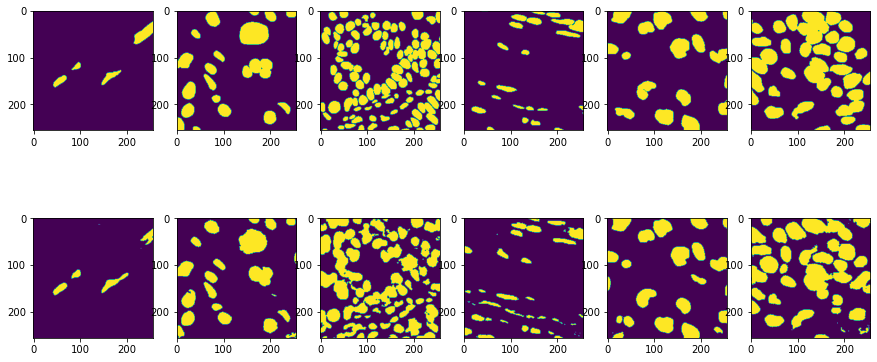

In [78]:
def num_gen():
    n1 = np.zeros(6)
    for i in range(6):
        value = randint(0, (preds_test.shape[0]-1))
        n1[i] = int(value)
    return n1
n1 = num_gen()
print(n1)
a0,a1,a2,a3,a4,a5 = n1[:]
f, axarr = plt.subplots(2,6, figsize=(15,7))
axarr[0,0].imshow(test_masks[int(a0),:,:])
axarr[0,1].imshow(test_masks[int(a1),:,:])
axarr[0,2].imshow(test_masks[int(a2),:,:])
axarr[0,3].imshow(test_masks[int(a3),:,:])
axarr[0,4].imshow(test_masks[int(a4),:,:])
axarr[0,5].imshow(test_masks[int(a5),:,:])
axarr[1,0].imshow(preds_test[int(a0),:,:])
axarr[1,1].imshow(preds_test[int(a1),:,:])
axarr[1,2].imshow(preds_test[int(a2),:,:])
axarr[1,3].imshow(preds_test[int(a3),:,:])
axarr[1,4].imshow(preds_test[int(a4),:,:])
axarr[1,5].imshow(preds_test[int(a5),:,:])